## הפקת דו"חות עומסי ביקורת 

In [1]:
# Refresh the Excel sheet with its connection ODC file
print('Refreshing connection...')

import win32com.client
xl = win32com.client.DispatchEx("Excel.Application")
wb = xl.workbooks.open(r'\\fsrv\Public_Folders\מפינט\חטיבת קדסטר\מערכת חדשה לניהול קדסטר - דוחות\View_AllProjects_currently_phase.xlsx')
xl.Visible = False
wb.RefreshAll()
wb.Save()
xl.Quit()

Refreshing connection...


In [2]:
# Read Cadastre Excel file
# and convert columns name to English
import pandas as pd

heb2eng_dic ={"מס' טופס":'form',
              'אליפסה':'elipse',
              'סוג פרויקט':'form_type',
              'מאפיינים':'feature',
              'מודד':'surveyor',
              'מודד מבקר':'mevaker_surveyor',
              'תאריך קבלת פרויקט':'form_date',
              'שלב ביקורת':'phase',
              'סטאטוס':'status',
              'תאריך סטאטוס':'status_date',
              'מסלול ביקורת':'lane',
              'יחידה מבוקשת':'unit_request',
              'יחידה':'unit',
              'שם המבצע':'worker',
              'ציון העבודה':'grade',
             'חומר ביסוס':'foundation',
             'מקדם חומר ביסוס':'foundation_coeff'} 


excel_path = r'\\fsrv\Public_Folders\מפינט\חטיבת קדסטר\מערכת חדשה לניהול קדסטר - דוחות\View_AllProjects_currently_phase.xlsx'
excel = pd.read_excel(excel_path).rename(columns=heb2eng_dic).dropna(how='all')

# Read Targets data (csv)

target_path = r'\\fsrv\Public_Folders\מפינט\חטיבת קדסטר\בקרה ומעקב\יעדים\Targets_global.csv'
targets = pd.read_csv(target_path, encoding='cp1255')

In [3]:
# Count elipses for each form & make sure the results are whole numbers and not floats
# excel['elipse_count'] = excel['tazars'].str.count("/").fillna(0).astype(int)

# replace unit text to English using dictionary
##need to figure how to use Hebrew##
excel['unit_fix'] = excel['Unit']
targets['unit_fix'] = targets['unit']

unit_dic = {'אגף תצ"ר':'מרכז',
               'מרחב חיפה והצפון':'חיפה',
               'מרחב הגליל':'גליל',
               'מרחב ירושלים':'ירושלים',
            'מרחב באר שבע והדרום':'דרום',
               'בקרה ומעקב':'בקרה ומעקב',
               'אגף קמ"ק':'קמ"ק',
               'אגף ה"ק':'הסדר קרקעות',
               'תחום מודד מבקר':'מודד מבקר',
               'גליל':'גליל',
               'חיפה':'חיפה',
               'ירושלים':'ירושלים',
               'מרכז':'מרכז',
               'דרום':'דרום'}

excel.replace({"unit_fix":unit_dic},inplace=True)

In [4]:
#Add columns of status == בתיקונים or in handle
excel['forms_in_repairs'] = excel.status.isin(['בתיקונים']).astype('int32')
excel['forms_in_handle'] = ~excel.status.isin(['בתיקונים'])
excel['form_count'] = excel['forms_in_repairs'] + excel['forms_in_handle']

In [5]:
# Filter data by phase, status & unit

status_list = ['בהקפאה' , 'מוקפא']   # 'בתיקונים' 

a_phase = excel[(excel.phase == 'פתיחת פרויקט') & (~excel.status.isin(status_list))].groupby('unit_fix',as_index=False, dropna=False, sort=True).sum()
b_phase = excel[(excel.phase == 'ביקורת מקדמית') & (~excel.status.isin(status_list))].groupby('unit_fix',as_index=False, dropna=False,sort=True).sum()
c_phase = excel[(excel.phase == 'שיוך למבקר') & (~excel.status.isin(status_list))].groupby('unit_fix',as_index=False, dropna=False, sort=True).sum()

In [6]:
# Drop 'הסדר קרקעות'  & and unnecessery columns from data

to_drop = ['onlineFormNum', 'License','LicenseRevSurv', 'factor', 'grade']


a_phase = a_phase[a_phase.unit_fix != 'הסדר קרקעות'].drop(columns=to_drop)
b_phase = b_phase[b_phase.unit_fix != 'הסדר קרקעות'].drop(columns=to_drop)
c_phase = c_phase[c_phase.unit_fix != 'הסדר קרקעות'].drop(columns=to_drop)

In [7]:
#Save Results to Excel files

a_phase.to_excel(r'\\fsrv\Public_Folders\מפינט\חטיבת קדסטר\מערכת חדשה לניהול קדסטר - דוחות\עומסים\פתיחת פרויקט.xlsx',
                 sheet_name='פתיחת פרויקט',
                 encoding='cp1255',
                 index=False)

b_phase.to_excel(r'\\fsrv\Public_Folders\מפינט\חטיבת קדסטר\מערכת חדשה לניהול קדסטר - דוחות\עומסים\ביקורת מקדמית.xlsx',
                 sheet_name='ביקורת מקדמית',
                 encoding='cp1255',
                 index=False)

c_phase.to_excel(r'\\fsrv\Public_Folders\מפינט\חטיבת קדסטר\מערכת חדשה לניהול קדסטר - דוחות\עומסים\שיוך למבקר.xlsx',
                 sheet_name='שיוך למבקר',
                 encoding='cp1255',
                 index=False)

In [8]:
targets_a = pd.merge(targets,a_phase, on='unit_fix', how='left')
targets_b = pd.merge(targets,b_phase, on='unit_fix', how='left')
targets_c = pd.merge(targets,c_phase, on='unit_fix', how='left')

on=['unit','reviewers']

phase_all = targets_a.merge(
    targets_b,on=on, copy=False,suffixes=('_B','_C')).merge(
    targets_c,on=on, copy=False).groupby(
    by='unit',as_index=False).sum().sort_values(by='unit')

 # pd.set_option('display.max_columns', 50)
phase_all['traffic_all'] = (phase_all['talar_count'] + phase_all['talar_count_B'] + phase_all['talar_count_C'])/phase_all['target_month']

In [9]:
mean_a = str(round(targets_a['talar_count'].mean(),1))
mean_b = str(round(targets_b['talar_count'].mean(),1))
mean_c = str(round(targets_c['talar_count'].mean(),1))

mean_traffic_all= str(round(phase_all['traffic_all'].mean(),2))

In [10]:
sum_a = str(targets_a['talar_count'].sum())
sum_b = str(targets_b['talar_count'].sum())
sum_c = str(targets_c['talar_count'].sum())

In [11]:
print('Plotting visualizations...')

Plotting visualizations...


In [12]:
# Plotting HTML with Bokeh
from bokeh.io import output_file, show
from bokeh.plotting import figure
from bokeh.layouts import row
from bokeh.models import Label, Title

from datetime import datetime

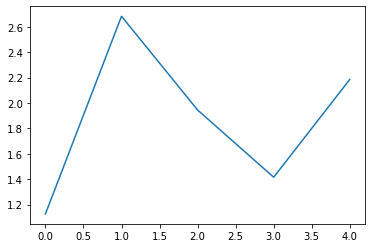

In [14]:
phase_all['traffic_all'].plot()

In [41]:
now = datetime.now() 
current_time = now.strftime("%H:%M:%S %d/%m/%Y")
current_time_text = str(current_time) + ' :נכון לתאריך'

output_file(r'\\fsrv\Public_Folders\מפינט\חטיבת קדסטר\מערכת חדשה לניהול קדסטר - דוחות\עומסים\כמות תכניות לשלב ביקורת.html', title='כמות תכניות לפי שלב ביקורת')

x0 = list(a_phase['unit_fix'])
x1 = list(b_phase['unit_fix'])
x2 = list(c_phase['unit_fix'])

y0 = a_phase['talar_count']
y1 = b_phase['talar_count']
y2 = c_phase['talar_count']


citation_s = Label(x=30, y=-300, x_units='screen', y_units='screen',
                 text= current_time_text, render_mode='css',
                 text_font_size='25pt',
                 background_fill_color='white', background_fill_alpha=1.0)

s1Title = 'כמות תכניות בשלב פתיחת פרויקט'
s1sumTitle = sum_a + ' :סכום'
s1meanTitle = mean_a + ' :ממוצע'

s2Title =   'כמות תכניות בשלב ביקורת מקדמית'
s2sumTitle = sum_b + ' :סכום'
s2meanTitle = mean_b + ' :ממוצע'


s3Title = 'כמות תכניות בשלב שיוך למבקר'
s3sumTitle = sum_c + ' :סכום'
s3meanTitle = mean_c + ' :ממוצע'



# create three plots
s1 = figure(x_range=x0, plot_height=550,plot_width=650, title=s1Title,
           toolbar_location='right', tools="pan,wheel_zoom,box_zoom,reset")
s1.vbar(x=x0, top=y0, width=0.9, fill_color='blue',line_width=4, line_color='black')

s2 = figure(x_range=x1, plot_height=550,plot_width=650, title=s2Title,
           toolbar_location='right', tools="pan,wheel_zoom,box_zoom,reset")
s2.vbar(x=x1, top=y1, width=0.9, fill_color='yellow',line_width=4, line_color='black')

s3 = figure(x_range=x2, plot_height=550,plot_width=650, title=s3Title,
           toolbar_location='right', tools="pan,wheel_zoom,box_zoom,reset")
s3.vbar(x=x2, top=y2, width=0.9, fill_color='purple',line_width=4, line_color='black')


s1.add_layout(Title(text=s1sumTitle, text_font_size="10pt"), 'above')
s1.add_layout(Title(text=s1meanTitle, text_font_size="10pt"), 'above')

s2.add_layout(Title(text=s2sumTitle, text_font_size="10pt"), 'above')
s2.add_layout(Title(text=s2meanTitle, text_font_size="10pt"), 'above')

s3.add_layout(Title(text=s3sumTitle, text_font_size="10pt"), 'above')
s3.add_layout(Title(text=s3meanTitle, text_font_size="10pt"), 'above')


s3.add_layout(citation_s)

for s in [s1,s2,s3]:
    s.xaxis.major_label_orientation = 45
    s.background_fill_color = "beige"
    s.background_fill_alpha = 0.5
    s.xaxis.major_label_text_font_size="12pt"
    s.yaxis.major_label_text_font_size="12pt"
    s.outline_line_width = 3
    s.outline_line_alpha = 0.9
    s.outline_line_color = "black"
    s.y_range.start = 0
    s.title.align = 'center'

# put the results in a row and uncomment to show
show(row(s1, s2, s3))


In [42]:
output_file(r'\\fsrv\Public_Folders\מפינט\חטיבת קדסטר\מערכת חדשה לניהול קדסטר - דוחות\עומסים\עומס משוקלל לתצר.html', title = 'עומס משוקלל לתצ"ר')

x = list(phase_all['unit'])
y = list(phase_all['traffic_all'])

pTiltle = mean_traffic_all +  ' :עומסי תצ"ר בחטיבת קדסטר, ' + 'ממוצע'
         
p = figure(x_range=x, plot_height=800,plot_width=1400, title=pTiltle,
           toolbar_location='right', tools="pan,wheel_zoom,box_zoom,reset")

p.vbar(x=x, top=y, width=0.9, fill_color='#7FFDA7',line_width=4, line_color='black')
p.title.text_font_size = "30pt"
p.title.align = 'center'

citation_p = Label(x=450, y=-150, x_units='screen', y_units='screen',
                 text=current_time_text, render_mode='css',
                 text_font_size='20pt',
                 background_fill_color='white', background_fill_alpha=1.0)
p.add_layout(citation_p)

p.background_fill_color = "#c1c3c2"
p.background_fill_alpha = 0.5

p.xaxis.axis_label = "יחידת ביקורת"
p.xaxis.axis_label_text_color = "black"
p.xaxis.axis_label_standoff = 10
p.xaxis.axis_label_text_font_size = "40pt"

p.yaxis.axis_label = "חודשי המתנה לתחילת ביקורת"
p.yaxis.axis_label_text_color = "black"
p.yaxis.axis_label_standoff = 10
p.yaxis.axis_label_text_font_size = "40pt"

p.xaxis.major_label_text_font_size="20pt"
p.yaxis.major_label_text_font_size="20pt"

p.outline_line_width = 7
p.outline_line_alpha = 0.9
p.outline_line_color = "black"

p.xgrid.grid_line_color = None
p.y_range.start = 0

# put the results in a row and uncomment to show
show(p)
